# Convenience module for pytorch training

## Imports

In [1]:
import writefile_run

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%%writefile_run train_utils.py


"""
Convenience module for pytorch training and visualization.
"""

import torch
import torch.nn as nn
from torch import optim
from pylab import *
from torch.utils.data import *
from IPython.display import *
from nb_figure import *
import os, time
import traceback

In [4]:
style.use(['dark_background'])
rcParams['axes.grid']=True
rcParams['font.size']=15
rcParams['figure.figsize']=18,7

In [5]:
%%writefile_run train_utils.py -a


def getTimeName():
    """Return the current time in format <day>-<month>_<hour><minute> for use in filenames."""
    from datetime import datetime
    t = datetime.now()
    return "{:02d}-{:02d}_{:02d}{:02d}".format(t.day,t.month,t.hour,t.minute)

In [6]:
%%writefile_run train_utils.py -a


def save_as_txt(obj, filename):
    """Save str(obj) to the given filename. Overwrites file if it exists."""
    s = str(obj)
    with open(filename, 'w') as f:
        f.write(s)

In [7]:
%%writefile_run train_utils.py -a


def decorate_plot(axes):
    """Label x axis as Epoch for each axis"""
    for ax in axes.reshape(-1):
        ax.set_xlabel("Epoch")

In [8]:
%%writefile_run train_utils.py -a


class Trainer():
    def __init__(self,
                 model,
                 trainOnBatch,
                 callback=None,
                 save_dir=None,
                 mode='nb'):
        """
        A trainer for training pytorch models.
        
        A top level directory given by save_dir is created, and the model architecture is saved.
        Every time loop is called, a run subdirectory is created and checkpoints are saved in that.
        
        The trainOnBatch function should perform the main train step, and return batch metrics.
        The optional callback can perform validation and return callback metrics.
        
        Make sure to call setup_metrics with names for each of the returned metrics in order.
        
        ---------
        Arguments
        ---------
        model: The model associated with this trainer
        trainOnBatch: a function with the following signature:
            trainOnBatch(model, batch, optimizer) -> tuple of batch metrics(scalars)
        callback: a function with the following signature:
            callback(model, val_loader) -> tuple of callback metrics(scalars)
        save_dir: the name of the directory to save all runs of this trainer in,
            if not provided, is the name of the model class
        mode: if 'nb', plot metric graphs and update displays, else just print info messages
        """
        
        
        if save_dir==None:
            save_dir=type(model).__name__    
        os.makedirs(save_dir,exist_ok=True)
        
        self.save_dir = save_dir
        self.trainOnBatch = trainOnBatch
        self.callback = callback
        self.mode = mode
        self.model = model
        
        # save model architecture
        save_as_txt(self.model, os.path.join(self.save_dir, 'arch.txt'))
        
        
    def save_model(self, epoch, directory):
        """Save the state dict of the model in the directory, 
        with the save name metrics at the given epoch."""
        # save state dict
        filename = "{}_epoch{:03d}".format(getTimeName(),epoch)
        
        for save_name_metric in self.save_name_metrics:
            filename = filename+"_{}{:.5f}".format(save_name_metric,
                                    self.metrics[save_name_metric][epoch-1])
        filename = filename+".statedict"
        
        torch.save(self.model.state_dict(), os.path.join(directory,filename))
    
    
    def setup_displays(self, batches, directory, **subplot_kwargs):
        """Set up IPython displays.
        
        batches: the number of batches in an epoch
        directory: the directory to save the metrics plot image
        """
        # First line display
        self.batch_info = display(Markdown(''), display_id='batch_info')

        # Progress bar
        self.epoch_progress = ProgressBar(batches)
        self.progress_bar = display(self.epoch_progress,display_id='progress_bar')

        # Time of last epoch display
        self.time_info = display(Markdown(''), display_id='time_info')

        self.callback_info = display(Markdown(''), display_id='callback_info')
        
        # Last saved model
        self.checkpoint_info = display(Markdown(''), display_id='checkpoint_info')
        
        # Metric plots
        self.nbfig = NBFigure(os.path.join(directory,"metric_plots.png")
                              ,*self.fig_grid, decorate_plot, **subplot_kwargs)
        
        # setup lines 
        self.lines = {}
        for i,group in enumerate(self.plot_grouping):
            # add a single point line for each group to respective axis
            ax = self.nbfig.getAxis(i)
            for metric in group:
                self.lines[metric], = ax.plot([0],[0])

            ax.legend(group)
            
        self.nbfig.display()
        self.nbfig.update()

    def setup_metrics(self,batch_metric_names, callback_metric_names=[], 
                    plot_grouping=None, save_name_metrics=None, fig_grid=(1,1)):
        """
        Setup the metrics dict, with the given names for the metrics returned
        by the batch and callback functions. 
        
        ---------
        Arguments
        ---------
        batch_metric_names: names of the metrics returned by the trainOnBatch function, 
            in order
        callback_metric_names(=[]): names of the metrics returned by the callback function, 
            in order
        plot_grouping(=None): a list of lists. Each list should contain the names of metrics to be 
            plotted in a single subplot. The index of each list corresponds to the index of
            the subplot, counted row major wise.
        save_name_metrics(=None): List of metric names which are added to the name of the saved 
            model checkpoints.
        fig_grid(=(1,1)): the number of rows and columns in the figure
           
        """
        
        # basic setups
        self.metrics = {}
        self.batch_metric_names = batch_metric_names
        self.callback_metric_names = callback_metric_names
        self.metric_names = self.batch_metric_names+self.callback_metric_names
        self.save_name_metrics = save_name_metrics if save_name_metrics != None else []
        
        # group all metrics into one if plot_grouping not specified
        if plot_grouping != None:
            self.plot_grouping = plot_grouping
        else:
            self.plot_grouping = [self.batch_metric_names+self.callback_metric_names]
        
        # initialize metric store
        for metric in self.metric_names:
            self.metrics[metric] = []
        
        self.fig_grid = fig_grid
        
        
    def update_metrics(self, batch_metrics, callback_metrics):
        """Update the stored lists for each metric with the given batch and callback metrics"""
        
        metrics = dict(zip(self.metric_names, batch_metrics+callback_metrics))
        for metric in self.metric_names:
            self.metrics[metric].append(metrics[metric])
        
        return metrics
        
    def update_lines(self, x_data):
        """Update the lines for each metric with the stored metric data, and the given x_data"""
        for metric in self.metric_names:
            self.lines[metric].set_data(x_data,self.metrics[metric])
            
        self.nbfig.update()
        
    def loop(self, epochs, train_loader, optimizer, val_loader=None, update_interval=10, save_every=1):
        """
        Perform a train loop for the given number of epochs.
        
        First, the optimizer and dataset specs are saved in a run directory.
        
        trainOnBatch is called for each batch in train loader, and the batch metrics of the last
        batch are recorded.
        
        callback is called after each epoch and the metrics it returned are also recorded.
        
        Plots of all metrics are updated live.
        
        Finally, model and optimzer state dicts are saved.
        
        Returns a dictionary of metrics
        
        ---------
        Arguments
        ---------
        epochs: number of epochs to train for
        train_loader: data loader which provides batches which are fed into trainOnBatch
        optimizer: optimizer which is fed into trainOnBatch
        val_loader(optional): fed into callback as a keyword argument val_loader
        update_interval: number of batches to update displays after
        save_every: number of epochs after which to save model state dict
        """
        
        run_dir = os.path.join(self.save_dir,"run_{}".format(getTimeName()))
        os.makedirs(run_dir,exist_ok=True)
        
        if self.mode == 'nb':
            self.setup_displays(len(train_loader), run_dir)
        
        # save optimizer spec
        save_as_txt(optimizer, os.path.join(run_dir,"optimizer_spec.txt"))
        
        # save dataset spec
        dataset_spec = "Train dataset:\n{}\nbatch size = {}\n".format(str(train_loader.dataset),
                                                                     train_loader.batch_size)
        if val_loader != None:
            dataset_spec += "Validation dataset:\n{}".format(str(val_loader.dataset))
        save_as_txt(dataset_spec, os.path.join(run_dir,"dataset_spec.txt"))
        
        # main train loop
        try:
            for e in range(epochs):

                i=0
                start = time.time()

                for batch in train_loader:
                    # Perform train step
                    batch_metrics = trainOnBatch(self.model, batch, optimizer)
                    
                    # Update displays
                    i+=1
                    if i%update_interval==0:
                        toprint = "Epoch {}, batch {}, lr={:.6f}".format(e+1,i,
                                    optimizer.state_dict()['param_groups'][0]['lr'])
                        
                        for k,metric in enumerate(self.batch_metric_names):
                            toprint = toprint + ", {}={:.5f}".format(metric, batch_metrics[k])

                        if self.mode=='nb':
                            self.batch_info.update(Markdown(toprint))
                            self.epoch_progress.progress = i
                            self.progress_bar.update(self.epoch_progress)
                        else:
                            print(toprint)

                # Update time for epoch
                t = time.time()-start
                toprint = "Last epoch took {:.2f} seconds".format(t)
                if self.mode=='nb':
                    self.time_info.update(Markdown(toprint))
                else:
                    print(toprint)

                # execute callback
                callback_metrics = ()
                if self.callback != None:
                    callback_metrics = self.callback(self.model, val_loader=val_loader)
                    
                    # update display
                    toprint = "Callback metrics:<br>"
                    for k,metric in enumerate(self.callback_metric_names):
                        toprint = toprint + "{}={:.5f}<br>".format(metric, callback_metrics[k])
                    
                    if self.mode == 'nb':
                        self.callback_info.update(Markdown(toprint))
                    else:
                        print(toprint)
                
                x_data = arange(e+1)+1
                
                # Update metrics after each epoch
                metrics = self.update_metrics(batch_metrics, callback_metrics)
                
                # update plots
                if self.mode == 'nb':
                    self.update_lines(x_data)

                # Checkpointing
                if e%(save_every)==0:
                    # save the state dict
                    self.save_model(e+1, run_dir)
                    
                    # update display
                    toprint = "<br>Saved model after epoch {} on {} with following metrics:<br>".format(e+1
                                                                                    ,time.ctime())
                    for metric in self.metric_names:
                        toprint = toprint+"{}={:.5f}<br>".format(metric,metrics[metric])
                    
                    if self.mode == 'nb':
                        self.checkpoint_info.update(Markdown(toprint))
                    else:
                        print(toprint)

        except KeyboardInterrupt:
            print("Exception occured, saving model and metrics")
            traceback.print_exc()
        finally:
            # save model dict
            self.save_model(e+1, run_dir)
            
            # save metrics
            torch.save(self.metrics,
                  os.path.join(
                        run_dir,                
                        "{}_metrics_epoch{:03d}.dict".format(type(self.model).__name__,e+1)
                    )
                  )
            
            # save optimizer state
            torch.save(optimizer.state_dict(),
                  os.path.join(
                        run_dir,                
                        "optimizer_state_epoch{:03d}.statedict".format(e+1)
                    )
                  )
            
            return self.metrics

# Setup a model for MNIST to demo the module

## Get the data

In [9]:
from torchvision.datasets import *
from torchvision.transforms import *

In [10]:
train_mnist = MNIST('/MNIST',download=True,transform=ToTensor())
test_mnist = MNIST('/MNIST',train=False,transform=ToTensor())

In [11]:
train_loader = DataLoader(train_mnist, batch_size=32,shuffle=True)
test_loader = DataLoader(test_mnist, batch_size=32,shuffle=True)

## The model

In [12]:
import torch.nn.functional as F

In [13]:
class MnistClassifier(nn.Module):
    def __init__(self, hid_size):
        super(MnistClassifier, self).__init__()
        
        self.hidden_layer = nn.Linear(28*28,hid_size)
        
        self.output_layer = nn.Linear(hid_size,10)
        
        
    def forward(self, input):
        input = input.view(-1,28*28)
        
        out = F.relu(self.hidden_layer(input))
        out = self.output_layer(out)
        
        return out

In [14]:
def trainOnBatch(model,batch,optimizer):
    outputs = model(batch[0])
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs,batch[1])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss = loss.detach().cpu().numpy()
    
    return loss,1

In [15]:
def callback(model, val_loader):
    
    return 2,3

In [16]:
mnist_model = MnistClassifier(400)

In [17]:
optimizer = optim.Adam(mnist_model.parameters())

In [18]:
trainer = Trainer(mnist_model, trainOnBatch, callback=callback)

trainer.setup_metrics(['loss','acc'],['val_loss','val_acc'],
                     plot_grouping=[['loss','val_loss'],['acc','val_acc']],
                     fig_grid=(1,2))

epochs = 10

Epoch 10, batch 1870, lr=0.001000, loss=0.00154, acc=1.00000

[=========================================================== ] 1870/1875

Last epoch took 12.91 seconds

Callback metrics:<br>val_loss=2.00000<br>val_acc=3.00000<br>

<br>Saved model after epoch 10 on Sun Jun 17 21:10:16 2018 with following metrics:<br>loss=0.01041<br>acc=1.00000<br>val_loss=2.00000<br>val_acc=3.00000<br>

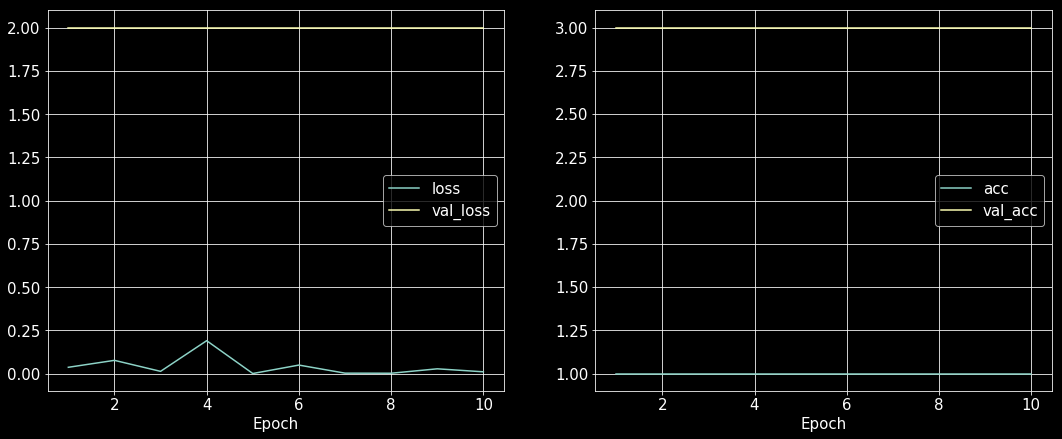

In [19]:
metrics = trainer.loop(epochs, train_loader, optimizer)